In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import random

In [2]:
# Directory and category setup
image_directory = r'/kaggle/input/sarscov2-ctscan-dataset'
size = 224
data = []

# Define categories
CATEGORIES = ['non-COVID', 'COVID']

In [3]:
for category in CATEGORIES:
    folder = os.path.join(image_directory, category)
    label = CATEGORIES.index(category)
    for image_name in os.listdir(folder):
        if image_name.endswith('.png'):  # Check for .png files
            image_path = os.path.join(folder, image_name)
            try:
                image = cv2.imread(image_path)
                image = Image.fromarray(image, 'RGB')
                image = image.resize((size, size))
                image_array = np.array(image) / 255.0  # Normalize pixel values
                data.append([image_array, label])
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")


In [4]:
# Shuffle data
random.shuffle(data)

In [5]:
# Separate features and labels
x = []
y = []

for features, labels in data:
    x.append(features)
    y.append(labels)

In [6]:
x = np.array(x)
y = np.array(y)

In [7]:
# Save the processed arrays (optional)
np.save('x.npy', x)
np.save('y.npy', y)


In [8]:
from sklearn.model_selection import StratifiedKFold
# Define K-fold cross-validation
k = 3  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

In [10]:
class SpatialAttentionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(16, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv4 = tf.keras.layers.Conv2D(1, kernel_size=kernel_size,  
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.math.sigmoid)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs,  axis=3)
        x = tf.stack([avg_out, max_out], axis=3) 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)
    

class ChannelAttentionModule(tf.keras.layers.Layer):
    def __init__(self, ratio=8):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(ChannelAttentionModule, self).__init__()
        self.ratio = ratio
        self.gapavg = tf.keras.layers.GlobalAveragePooling2D()
        self.gmpmax = tf.keras.layers.GlobalMaxPooling2D()
        
    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(input_shape[-1]//self.ratio, 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
    
        self.conv2 = tf.keras.layers.Conv2D(input_shape[-1], 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
        super(ChannelAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # compute gap and gmp pooling 
        gapavg = self.gapavg(inputs)
        gmpmax = self.gmpmax(inputs)
        gapavg = tf.keras.layers.Reshape((1, 1, gapavg.shape[1]))(gapavg)   
        gmpmax = tf.keras.layers.Reshape((1, 1, gmpmax.shape[1]))(gmpmax)   
        # forward passing to the respected layers
        gapavg_out = self.conv2(self.conv1(gapavg))
        gmpmax_out = self.conv2(self.conv1(gmpmax))
        return tf.math.sigmoid(gapavg_out + gmpmax_out)
    
    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[3]
        return (input_shape[0], output_len)

In [11]:
from tensorflow.keras.layers import Conv2D, Multiply

def pixel_attention(x, nf):
    # Apply convolution to capture spatial dependencies
    conv = Conv2D(nf, 3, padding='same', activation='relu')(x)
    
    # Apply convolution to obtain attention scores
    attention_scores = Conv2D(1, 1, padding='same', activation='sigmoid')(conv)
    
    # Multiply attention scores with input features
    weighted_features = Multiply()([x, attention_scores])
    
    return weighted_features

In [12]:
def tta_module(x, nf):
    x_1by1 = Conv2D(nf, (1,1), activation='relu',  padding='same')(x)
    x_3by3 = Conv2D(nf, (3,3), activation='relu',  padding='same')(x)
    
    x_pa = pixel_attention(x_3by3, nf)
    
    x_ca = ChannelAttentionModule()(x_1by1)
    
    x_sa = SpatialAttentionModule()(x_1by1)
    
    x_casa = Multiply()([x_sa, x_ca])
    
    x_out = Concatenate()([x_casa, x_pa])
    return x_out

In [13]:
#ConvolutionalTokenizer class that converts images into tokenized feature representations
class ConvolutionalTokenizer(keras.Model):
    def __init__(self, kernel_size=3, stride=1, padding=1, pooling_kernel_size=3, pooling_stride=2, 
                 conv_layers=3, num_output_channels=[64, 128, 128], **kwargs):
        super(ConvolutionalTokenizer, self).__init__(**kwargs)
        
        self.conv_model = keras.Sequential()  # Sequential container for the convolutional layers
        
        # Loop through the desired number of convolutional layers
        for i in range(conv_layers):
            self.conv_model.add(L.SeparableConv2D(num_output_channels[i], kernel_size=kernel_size, strides=stride, padding="same",
                                                 use_bias=False, activation="relu", depth_multiplier=1, 
                                                 depthwise_initializer="he_normal", pointwise_initializer="he_normal"))
                        
            self.conv_model.add(L.MaxPool2D(pool_size=pooling_kernel_size, strides=pooling_stride, padding="same"))
        
    def call(self, images):
       
        outputs = self.conv_model(images)
        
        # Flatten the output to produce tokens of shape (batch_size, sequence_length, channels)
        flattened = tf.reshape(outputs, (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[3]))
        return flattened

In [14]:
# Define a PositionEmbedding class that adds positional encodings to the tokenized input
class PositionEmbedding(L.Layer):
    def __init__(self):
        super(PositionEmbedding, self).__init__()

    def build(self, input_shape):
        # Get the sequence length and projection dimension from the input shape
        sequence_length = input_shape[1]  
        projection_dim = input_shape[-1]  
        
        # Create an embedding layer to generate positional encodings
        self.embedding = L.Embedding(input_dim=sequence_length, output_dim=projection_dim)

    def call(self, inputs):
        # Generate the position indices and apply the embedding layer
        sequence_length = tf.shape(inputs)[1]  
        positions = tf.range(start=0, limit=sequence_length, delta=1)
        return self.embedding(positions)


In [15]:
def mlp(x, mlp_dim, dim, dropout_rate=0.1):
    x = L.Dense(mlp_dim, activation='swish')(x)
    x = L.Dropout(dropout_rate)(x)
    x = L.Dense(dim)(x)  # The output dimension is set to dim
    x = L.Dropout(dropout_rate)(x)
    return x

def transformer_encoder(x, num_heads, dim, mlp_dim):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(num_heads=num_heads, key_dim=dim)(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, mlp_dim, dim)  # The output dimension of MLP is dim
    
    # Ensure skip connection has the same dimension as x
    if skip_2.shape[-1] != x.shape[-1]:
        skip_2 = L.Dense(x.shape[-1])(skip_2)
    
    x = L.Add()([x, skip_2])

    return x

In [16]:
# Compact convolutional transformer block
def tta_cct_block(inputs, num_filters, dim, num_layers=1):
    
    # TTA Module applied to input features
    x_tta = tta_module(inputs, num_filters)
    
    tokenizer = ConvolutionalTokenizer() 
    tokenized = tokenizer(inputs)  
    
    position_embedding = PositionEmbedding()(tokenized)  
    x = tokenized + position_embedding  

    # Apply transformer layers to the tokenized inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads=4, dim=dim, mlp_dim=dim*2)

    # Reshape the tokenized features back to spatial dimensions (height x width)
    B, P, N = x.shape  
    H = W = int(P**0.5)  # Calculate the height and width from the sequence length (assuming square)
    

    x = L.Reshape((H, W, N))(x)

    # Upsample to match the input dimensions
    x = L.UpSampling2D(size=(inputs.shape[1] // H, inputs.shape[2] // W), interpolation="bilinear")(x)

    
    x = L.SeparableConv2D(filters=inputs.shape[-1], kernel_size=1, padding='same', use_bias=False)(x)
    x = L.BatchNormalization()(x)  
    x = L.Activation('swish')(x)  

     
    x = L.Concatenate(name = "Vizualization_Map")([x, x_tta])  

    
    x = L.SeparableConv2D(filters=num_filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = L.BatchNormalization()(x)  
    x = L.Activation('swish')(x)  

    return x




In [17]:
def build_model(input_shape):
    inputs = Input(shape=(224,224,3))
    
    
    x = SeparableConv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # First TTA-CCT Block
    x = tta_cct_block(x, num_filters=128, dim=128, num_layers=4)
    
    x = SeparableConv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second TTA-CCT Block
    # x = tta_cct_block(x, num_filters=256, dim=64, num_layers=4)
    
    x = SeparableConv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SeparableConv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SeparableConv2D(filters=512, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SeparableConv2D(filters=1024, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
     # Flatten the output
    x = GlobalAveragePooling2D()(x)
    
        # Dense layers
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    
        # Final classification layer (binary output)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

In [18]:
# Build the model for this fold
model = build_model(input_shape=(224, 224, 3))

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 224, 224, 64)   │            219 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convolutional_tokenizer   │ (None, 196, 128)       │         30,976 │ max_pooling2d[0][0]    │
│ (ConvolutionalTokenizer)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding        │ (196, 128)             │         25,088 │ convolutional_tokeniz… │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 196, 128)       │              0 │ convolutional_tokeniz… │
│                           │                        │                │ position_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 196, 128)       │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 196, 128)       │        263,808 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 196, 128)       │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 196, 128)       │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 196, 256)       │         33,024 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 196, 256)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)      

 Total params: 4,230,861 (16.14 MB)

 Trainable params: 4,221,997 (16.11 MB)

 Non-trainable params: 8,864 (34.62 KB)

In [19]:

from tensorflow.keras import mixed_precision
# Enable mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)  # Use set_global_policy instead of set_policy

In [20]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler

In [23]:
def lr_schedule(epoch, lr):
    """
    Custom learning rate scheduler: reduces the learning rate after specific epochs.
    """
    if epoch < 10:
        return 1e-4
    elif epoch < 30:
        return 5e-5
    elif epoch < 50:
        return 1e-5
    else:
        return 5e-6


In [24]:
fold_no = 1
# Placeholder for storing metrics
val_accuracies = []
val_losses = []
confusion_matrices = []
classification_reports = []


In [26]:
for train_index, val_index in skf.split(x, y):
    print(f"Training fold {fold_no}...")

    # Split the data into training and validation sets
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Build the model for this fold
    model = build_model(input_shape=(224, 224, 3))

     # AdamW optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)


    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # ModelCheckpoint callback to save the best model
    checkpoint_filepath = f'best_model_fold_{fold_no}.keras'
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[model_checkpoint,lr_scheduler],  # Add the checkpoint callback
        verbose=1
    )

    # Load the best model for evaluation
    model.load_weights(checkpoint_filepath)

    # Save the complete model after training
    complete_model_path = f'complete_model_fold_{fold_no}.keras'
    model.save(complete_model_path)
    print(f"Saved the complete model for fold {fold_no} at {complete_model_path}")

    # Evaluate on validation data
    val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Generate predictions
    y_pred = (model.predict(x_val) > 0.5).astype("int32")

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(cm)
    report = classification_report(y_val, y_pred, output_dict=True)
    classification_reports.append(report)

    print(f"Validation accuracy for fold {fold_no}: {val_accuracy:.4f}")
    print(f"Validation loss for fold {fold_no}: {val_loss:.4f}")

    fold_no += 1

# Calculate and print average validation accuracy and loss across all folds
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)
print(f"\nAverage validation accuracy across all folds: {avg_val_accuracy:.4f}")
print(f"Average validation loss across all folds: {avg_val_loss:.4f}")

Training fold 1...

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5306 - loss: 0.8440
Epoch 1: val_accuracy improved from -inf to 0.49456, saving model to best_model_fold_1.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 99s 472ms/step - accuracy: 0.5310 - loss: 0.8433 - val_accuracy: 0.4946 - val_loss: 0.7003 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6807 - loss: 0.6310
Epoch 2: val_accuracy did not improve from 0.49456
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.6809 - loss: 0.6306 - val_accuracy: 0.4946 - val_loss: 1.4163 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7587 - loss: 0.5235
Epoch 3: val_accuracy did not improve from 0.49456
104/104 ━━━━━━━━━━━━━━━━━━━━

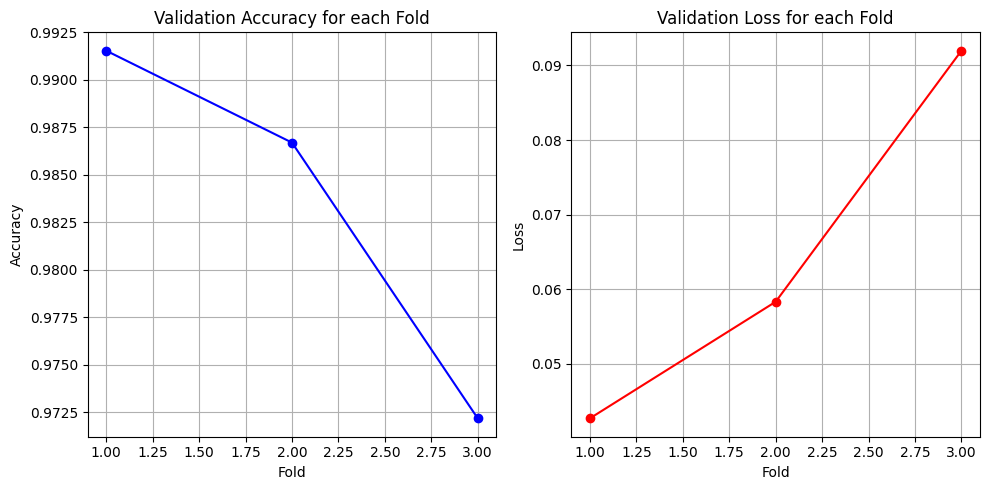

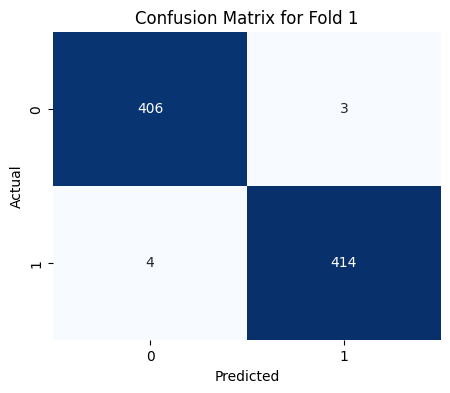

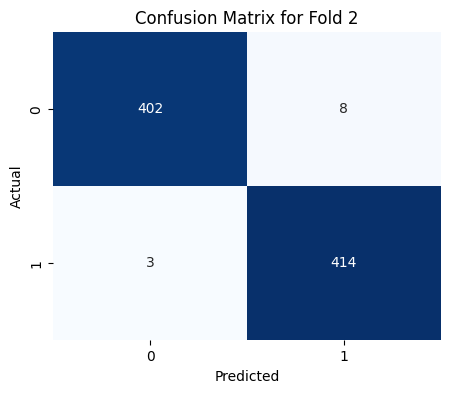

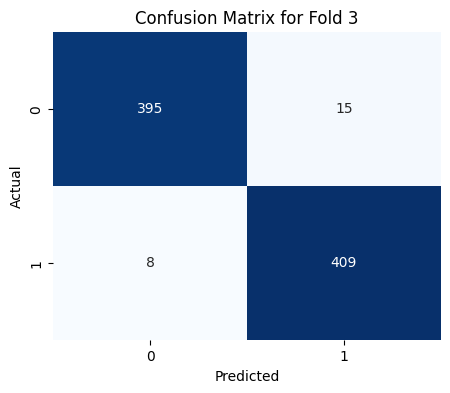

Classification Report for Fold 1
              precision    recall  f1-score     support
0              0.990244  0.992665  0.991453  409.000000
1              0.992806  0.990431  0.991617  418.000000
accuracy       0.991536  0.991536  0.991536    0.991536
macro avg      0.991525  0.991548  0.991535  827.000000
weighted avg   0.991539  0.991536  0.991536  827.000000


Classification Report for Fold 2
              precision    recall  f1-score     support
0              0.992593  0.980488  0.986503  410.000000
1              0.981043  0.992806  0.986889  417.000000
accuracy       0.986699  0.986699  0.986699    0.986699
macro avg      0.986818  0.986647  0.986696  827.000000
weighted avg   0.986769  0.986699  0.986698  827.000000


Classification Report for Fold 3
              precision    recall  f1-score     support
0              0.980149  0.963415  0.971710  410.000000
1              0.964623  0.980815  0.972652  417.000000
accuracy       0.972189  0.972189  0.972189    0.972189
m

AttributeError: 'float' object has no attribute 'keys'

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Plot validation accuracy and loss for each fold
def plot_metrics(val_accuracies, val_losses, k):
    folds = range(1, k+1)
    
    # Plot Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(folds, val_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for each Fold')
    plt.grid(True)
    
    # Plot Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(folds, val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.title('Validation Loss for each Fold')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot Confusion Matrix for each fold
def plot_confusion_matrices(confusion_matrices, k):
    for i in range(k):
        plt.figure(figsize=(5, 4))
        sns.heatmap(confusion_matrices[i], annot=True, fmt="d", cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for Fold {i + 1}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

# Print Classification Report for each fold and the average report
def print_classification_reports(classification_reports, k):
    # Ensure that each entry is a dictionary, not a float
    for i in range(k):
        print(f"Classification Report for Fold {i + 1}")
        print(pd.DataFrame(classification_reports[i]).transpose())
        print("\n")
    
    # Calculate average classification report across all folds
    avg_report = {}
    # Ensure that the classification report is in dictionary format
    if isinstance(classification_reports[0], dict):
        for key in classification_reports[0].keys():
            avg_report[key] = {metric: np.mean([classification_reports[i][key][metric] for i in range(k)])
                               for metric in classification_reports[0][key].keys()}
    else:
        print("Error: classification_reports does not contain dictionaries.")

    print("Average Classification Report across all Folds")
    print(pd.DataFrame(avg_report).transpose())
    print("\n")

# Call the plotting functions after cross-validation
plot_metrics(val_accuracies, val_losses, k)

plot_confusion_matrices(confusion_matrices, k)

print_classification_reports(classification_reports, k)


In [28]:
import pandas as pd

# Initialize average classification report
avg_classification_report = {}

# Get all classes from the first report
classes = classification_reports[0].keys()

# Initialize the structure for aggregation
for cls in classes:
    if isinstance(classification_reports[0][cls], dict):
        avg_classification_report[cls] = {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}
    else:
        avg_classification_report[cls] = 0  # For 'accuracy', which is a float

# Aggregate the metrics across all folds
for report in classification_reports:
    for cls, metrics in report.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                avg_classification_report[cls][metric] += value
        else:
            avg_classification_report[cls] += metrics  # For 'accuracy'

# Calculate the average for each metric
num_folds = len(classification_reports)
for cls, metrics in avg_classification_report.items():
    if isinstance(metrics, dict):
        for metric in metrics:
            avg_classification_report[cls][metric] /= num_folds
    else:
        avg_classification_report[cls] /= num_folds  # For 'accuracy'

# Convert accuracy (float) into a dictionary for consistent formatting
if 'accuracy' in avg_classification_report:
    acc_value = avg_classification_report['accuracy']
    avg_classification_report['accuracy'] = {
        'precision': acc_value,
        'recall': acc_value,
        'f1-score': acc_value,
        'support': acc_value  # For display purposes
    }

# Convert the averaged classification report to a pandas DataFrame
report_df = pd.DataFrame.from_dict(avg_classification_report, orient='index')

# Rearrange columns to match the required output format
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]

# Display the formatted classification report
print("\nAveraged Classification Report across all folds:\n")
print(report_df.to_string(float_format='%.6f'))



Averaged Classification Report across all folds:

              precision   recall  f1-score    support
0              0.987662 0.978856  0.983222 409.666667
1              0.979490 0.988017  0.983719 417.333333
accuracy       0.983474 0.983474  0.983474   0.983474
macro avg      0.983576 0.983437  0.983471 827.000000
weighted avg   0.983543 0.983474  0.983473 827.000000


In [29]:
# Save the entire model
model.save('complete_model.keras')  # Use .keras format (recommended) or .h5